In [ ]:
!pip install deepface

     |████████████████████████████████| 62 kB 161 kB/s 
     |████████████████████████████████| 2.3 MB 11.1 MB/s 


In [8]:
# Module / package imports
import cv2
import os
import random
import shutil
import zipfile
import tarfile
import requests
import itertools
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import matplotlib.image   as mpimg
import matplotlib.patches as patches
import tensorflow         as tf

tf_version = int(tf.__version__.split(".")[0])

if tf_version == 2:
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    from tensorflow.keras.preprocessing import image
else:
    from keras.preprocessing import image

from PIL                     import Image
from io                      import BytesIO
from deepface                import DeepFace
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

# ==============================================================================

ROOT_DIR     = os.path.dirname(os.path.realpath("__file__"))
DATASETS_DIR = os.path.join(ROOT_DIR, "data_sets")

#                0    ,     1    ,      2      ,     3     ,      4      ,      5     ,     6    ,   7
BACKENDS = [  "opencv",     "ssd",       "dlib",    "mtcnn", "retinaface", "mediapipe"]
MODELS   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",   "DeepFace",    "DeepID", "ArcFace", "Dlib"]

if len(tf.config.list_physical_devices('GPU')) == 0:
  print('!!! WARNING !!!: No GPU found! This script might take longer\
  than expected if executed using only CPUs!')

# ==============================================================================

class FR_performance:
    """
    Face recognition performance class. Stores performance results and metrics
    for the face recognition system using the specified face detector and
    verifier.
    
    Attributes:
        - On initialization:
            1. name - name of result (typically 
                <face detector>_plus_<face verifier>)
            2. files - name of files relating to these results
            3. pred - predictions or face recognition system output (vector
                of booleans representing match / no match for each file)
                    
        - After successful 'calc_performance' call:
            4. acc - system's accuracy as a decimal
            5. cm  - system's confusion matrix
            6. tn  - system's true  negatives (absolute value)
            7. fp  - system's false positives (absolute value)
            8. fn  - system's false negatives (absolute value)
            9. tp  - system's true  positives (absolute value)
            
        - After successful 'plot_performance' call:
            10. txt  - text printed on the performance
            11. disp - handle to performance plot
            
    Methods:
        calc_performance(ground_truth) - calculates the performance of the 
            face recognition system by comparing the system's results with
            the ground truth provided.
            
        plot_performance() - plots a confusion matrix showing the system's
            performance, along with some important metrics: false positives,
            false negatives, true positives, true negatives and accuracy.
    """
    def __init__(self, name, output):
        """
        Initializes the face recognition performance object.
        
        Inputs:
            1. name - name of result
            2. output - dictionary containing the file names and results
            
        Outputs:
            Updates the following attributes:
                a. name
                b. files
                c. pred
        """
        self.name  = name
        self.files = output["file"]
        self.pred  = output["result"]
        
    def calc_performance(self, ground_truth):
        """
        Calculates the performance of the face recognition system by
        comparing the system's results with the ground truth provided.
        
        Input:
            1. ground_truth - array of boolean values indicating if
                the specific file has a match in the gallery or not
                
        Outputs:
            Updates the following attributes:
                a. pred
                b. acc
                c. cm
                d. tn
                e. fp
                f. fn
                g. tp
        """
        # Converts predictions to numpy array if they are not
        if not isinstance(self.pred, np.ndarray):
            self.pred = np.array(self.pred)
            
        # Calculating accuracy
        if not isinstance(ground_truth, np.ndarray):
            ground_truth = np.array(ground_truth)   
        self.acc = np.sum(ground_truth == self.pred) \
                 / ground_truth.shape[0]
        
        # Calculating confusion matrix and other performance metrics
        self.cm = confusion_matrix(ground_truth, self.pred)
        self.tn, self.fp, self.fn, self.tp = self.cm.ravel()
        
    def plot_performance(self):
        """
        Plots a confusion matrix showing the system's performance, along
        with some important metrics: false positives, false negatives,
        true positives, true negatives and accuracy.
        
        Input:
            None
                
        Outputs:
            Updates the following attributes:
                a. txt
                b. disp
        """
        try:
            # Creating performance text
            self.txt = "Accuracy: {:.3f}%".format(100*self.acc).center(30) \
                     + "\n" + f"True positive: {self.tp}".rjust(20)        \
                     + f" | False positive: {self.fp}".rjust(20) + "\n"    \
                     + f"True negative: {self.tn}".rjust(20)               \
                     + f" | False negative: {self.fn}".rjust(20)

            # Create confusion matrix display
            self.disp = ConfusionMatrixDisplay(confusion_matrix=self.cm,
                                       display_labels=["negative", "positive"])
            
            # Plots the results & text
            self.disp.plot(cmap="Blues")
            plt.figtext(0.5, -0.2, self.txt, wrap=True,
                        horizontalalignment='center', fontsize=12);
            plt.title(self.name);
            
        except Exception as excpt:
            print(excpt)  # print exception
            print(f"Type: {type(excpt)} | Args: {excpt.args}")
            print("Try calling 'calc_performance' once then calling this method.")
            
# ============================================================================

class DownloadExtract:
  """
  Simple class to download and extract zip, tar or tar.gz file from url.
  """

  def download_and_extract(url, destination, file_is="", verbose=0):
    """
    Downloads and extracts a zip, tar, tar.gz or tgz file from the specified
    'url' to the destination folder 'destination'. If the file specified is not 
    one of those types then this method aborts with a warning.

    Inputs:
      1. url - string specifying the file's URL.

      2. destination - string specifying a target directory for extraction.

      3. file_is - string specifying the file type ([], zip, tar or tar.gz).
         If file_is='' is used then this function tries to determine the file
         type automatically from the file's URL.

      4. verbose - controls the text output of the function ([0 = quiet],
         1 = verbose).
    
    Outputs:
      None
    
    Example call:
      DownloadExtractZip.download_and_extract(url, destination, verbose=0)
    """
    # Variable to skip last verbose statement
    skip_last_msg = False

    # Assigns a file_type number according to the 'file_is' input
    if file_is == 'zip':
      file_type = 1
    elif file_is == 'tar':
      file_type = 2
    elif file_is == 'tar.gz' or file_is == 'tgz':
      file_type = 3
    else:
      file_type = 0

    if verbose:
      print('Downloading Started')
    
    # Downloading the file by sending the request to the URL
    req = requests.get(url, allow_redirects=True)
    if verbose:
      print('Downloading Completed\nExtracting ...', end=' ')

    # Determines file type from url and extracts the file
    if url.endswith("zip") or file_type == 1:
      zfile = zipfile.ZipFile(BytesIO(req.content))
      zfile.extractall(destination)

    elif url.endswith("tar") or file_type == 2:
      tar = tarfile.open("r:", fileobj=BytesIO(req.content))
      tar.extractall(destination)
      tar.close()

    elif url.endswith("tar.gz") or url.endswith("tgz") or file_type == 3:
      tar = tarfile.open("r:gz", fileobj=BytesIO(req.content))
      tar.extractall(destination)
      tar.close()

    else:
      skip_last_msg=True
      print('failed!\n[Error] File type was not recognized \
            (not zip, tar, tar.gz or tgz)')

    if verbose and not skip_last_msg:
      print('done!')

# ==============================================================================

# Create directory function
def create_dir(dir_path):
  """
  Creates a directory at the specified directory path 'dir_path' IF it does not
  exist. Returns a status of 0 is the directory was successfully created and 
  returns a status of 1 if a directory already exists.

  Inputs:
    1. dir_path - directory path of new directory.
    
  Outputs:
    1. status - 0 to indicate success (directory creation) or 1 to indicate
       failure (directory already exists)
    
  Example call:
    status = create_dir("./this/is/a/directory/path")
  """
  # Create directory
  try:
    os.makedirs(dir_path)
    status = 0
  except FileExistsError:
    # Directory already exists
    status = 1

  return status

# ==============================================================================

def split_single_multiple_imgs(dataset_dir):
    """
    Splits the LFW data set into two sets:
        1. single - each person has only a SINGLE image
        2. multiple - each person has MULTIPLE images (>1)

    Input:
        1. dataset_dir - full path of the LFW data set directory

    Output:
        1. dictionary containing the names of the directories:
            a. Of people with only 1 image (key: 'single')
            b. Of people with more than 1 images (key: 'multiple')

    Example call:
        splits = split_single_multiple_imgs(dataset_dir)
        splits['single']   # these directories contain only 1 image
        splits['multiple'] # these directories contain >1 images
    """

    # Initializes lists
    multiple_imgs = []
    single_img    = []

    # Loops through each directory
    for dir in os.listdir(dataset_dir):
        dir_fp = os.path.join(dataset_dir, dir) # gets full path

        # Only consider directories (ignore files)
        if os.path.isdir(dir_fp):
            nfiles = len(os.listdir(dir_fp)) # number of files in directory

            # Determines if the directory has multiple images and assigns it
            # to the appropriate list
            if nfiles > 1:
                multiple_imgs.append(dir)
            else:
                single_img.append(dir)

    return {"single":single_img, "multiple":multiple_imgs}

# ==============================================================================

def create_sub_LFW(save_path, dataset_root, p1_idxs=[], p1_num=100, p2_num=100,
                    p2_idxs=[], force_create=False):
    """
    Creates a subset of the LFW data set. This subset consists of a mixture of:
        1. 'p1_num' directories of people with only 1 image available.
        2. 'p2_num' directories of people with >1 images available.

    These directories are 'linearly' sampled. Alternatively, the user can
    provide a numpy array of indices corresponding to which subdirectories 
    they wish to include in the subset. Note that 'p1_idxs' and 'p2_idxs'
    correspond indices of subdirectories described as above and if they are
    provided then 'p1_num' and 'p2_num' have no effect.

    For example:
        p1_idxs = numpy.array([1, 2])    -> ignores 'p1_num'
        p2_idxs = numpy.array([1, 2, 3]) -> ignores 'p2_num'

    Result in:
        The subset will consist of the first 2 subdirectories with only 1 image
        and the first 3 subdirectories with more than 1 images.

    In all cases, the first image of EACH subdirectory that has multiple images
    will be used to create the gallery (known faces). Everything else will be
    treated as faces in the wild, called targets (unknown faces)

    The 'force_create' flag controls if this function should create the subset
    even if 'save_path' points to an already existing directory (assumed to be a
    pre-existing data set). Note that if force_create=True then the old data set
    is DELETED - so use it with care!

    Inputs:
        1. save_path - full path to location of the new data set

        2. dataset_root - full path of the LFW data set

        3. p1_idxs - numpy array of indices that determine which subdirectories
            of people with 1 image should be included. If not provided, then
            'p1_num' linearly-spaced subdirectories are selected ([p1_idxs=[]]).

        4. p1_num - number of single image subdirectories to be selected
            ([p1_num=100])

        5. p2_idxs - numpy array of indices that determine which subdirectories
            of people with >1 images should be included. If not provided, then
            'p2_num' linearly-spaced subdirectories are selected ([p2_idxs=[]]).

        6. p2_num - number of multiple image subdirectories to be selected
            ([p2_num=100])

        7. force_create - flag indicating if this function should create the
            data set even if a directory exists in 'save_path'. This function
            assumes that a directory in 'save_path' is a data set. If 
            'force_create=True', IT WILL DELETE EVERYTHING IN 'save_path', so
            use it with caution ([force_create=False])!

    Output:
        None (creates a data set at 'save_path')

    Example call:
        SAVE_PATH = I/want/to/save/the/dataset/here
        LFW_ROOT  = this/is/where/LFW/is/located

        # Creating custom indicies
        p1_idxs = numpy.array([1, 2])
        p2_idxs = numpy.array([1, 2, 3, 4, 5])

        # This will result in a very small subset of LFW
        create_sub_LFW(SAVE_PATH, LFW_ROOT, p1_idxs=p1_idxs, p2_idxs=p2_idxs)
    """

    if os.path.isdir(save_path) and not force_create:
        # Aborts creating the data set as it already exists
        print("LFW subset data set already exists!")
        return None
    
    elif os.path.isdir(save_path) and force_create:
        # Since 'force_create' is True, delete the previous data set found
        print("Forcing the creation of the data set. " \
              + "Removing existing data set.")
        shutil.rmtree(save_path) # should aways work because 'save_path' exists

    else:
        # Otherwise the data set does not exist, so proceed with creating it.
        # This is similar to when 'force_create=True' but without the need to 
        # delete the previous data set (because there isnt any).
        #       - This is kept here to improve code reability / understanding
        pass

    # -------------------------------------------------------------------------

    # Creates the new dataset root directory
    gallery_path = os.path.join(save_path, "gallery")
    targets_path = os.path.join(save_path, "targets")

    os.mkdir(save_path)    # path to the new dataset
    os.mkdir(gallery_path) # path to the 'known'   people (gallery)
    os.mkdir(targets_path) # path to the 'unknown' people (targets)

    # -------------------------------------------------------------------------

    # Splits dataset into people with a single image and people with multiple
    # images
    splits   = split_single_multiple_imgs(dataset_root)
    single   = splits["single"]
    multiple = splits["multiple"]

    # Create partition arrays (if not provided). If provided assumes it is
    # properly constructed... maybe it shouldnt?
    if not isinstance(p1_idxs, np.ndarray):
        p1_idxs = np.linspace(0,   len(single)-1, num=p1_num).astype(int)

    if not isinstance(p2_idxs, np.ndarray):
        p2_idxs = np.linspace(0, len(multiple)-1, num=p2_num).astype(int)
    
    # -------------------------------------------------------------------------

    # First we will deal with single images
    for idx in p1_idxs:
        source_path  = os.path.join(dataset_root, single[idx])
        targets_path = os.path.join(save_path, "targets", single[idx])

        # Copy the entire directory
        try:
            shutil.copytree(source_path, targets_path)
        except Exception as excpt:
            print("Type: ", type(excpt),
                  " | Arguments: ", excpt.args,
                  " | Exception: ", excpt)

    # -------------------------------------------------------------------------

    # Then we will deal with multiple images and create the gallery:
    for idx in p2_idxs:
        source_path  = os.path.join(dataset_root, multiple[idx])
        gallery_path = os.path.join(save_path, "gallery", multiple[idx])
        targets_path = os.path.join(save_path, "targets", multiple[idx])
    
        # Create a directory in gallery and targets with person's name if needed
        if not os.path.isdir(gallery_path):
            os.mkdir(gallery_path)
    
        if not os.path.isdir(targets_path):
            os.mkdir(targets_path)

        # We will use the first file to build our gallery
        # Get the files inside the current directory
        file_names = os.listdir(source_path)
        for j, name in enumerate(file_names):

            try:
                if j == 0:
                    shutil.copy2(os.path.join(source_path , name), 
                                 os.path.join(gallery_path, name))
                else:
                    shutil.copy2(os.path.join(source_path , name), 
                                 os.path.join(targets_path, name))
            except FileNotFoundError:
                pass

    return None

# ==============================================================================

def get_LFW_ground_truth(dataset_root):
    """
    Gets the ground truth from the LFW data set (or subsets assuming they
    have the same structure). Returns the ground truth names (ids), targets
    names (ids) and each targets' match to the ground truth.
    
    Input:
        1. dataset_root - full path to the root directory of the LFW data set
    
    Outputs:
        1. list with each person's name in the gallery
        2. dictionary where each file name is a key and has a corresponding
            boolean (item) indicating if this file has a positive match in
            the gallery
            
    Example call:
        LFW_ROOT = this/is/my/path/to/the/LFW/data_set
        gt_ids, tgt_ids, tgt_mtch = get_LFW_ground_truth(LFW_ROOT)
    """
    # Sets up the gallery and targets paths
    gallery_dir = os.path.join(dataset_root, "gallery")
    targets_dir = os.path.join(dataset_root, "targets")
    
    # Loops through all directories in 'gallery', obtaining the ground truth
    # from the directory names
    gt_ids = []
    for root, dirs, _junk in os.walk(gallery_dir):
        for name in dirs:
            files = os.listdir(os.path.join(root, name))
            # The file names are Name_Surname_XXXX.jpg so just ignore the last
            # 9 characters (as we dont need _XXXX.jpg, just the person's name)
            gt_ids.append(files[0][:-9].lower())
     
    # Loops through all directories in 'target', obtaining the targets' names
    # from the directory names and trying to match them to the ground truths
    tgt_mtch = dict()
    for root, dirs, _junk in os.walk(targets_dir):
        for name in dirs:
            files = os.listdir(os.path.join(root, name))
            # The file names are Name_Surname_XXXX.jpg so just ignore the last
            # 9 characters (as we dont need _XXXX.jpg, just the person's name)
            for file in files:
                file = file[:-4].lower() # gets the file name without extension
                
                # Append the new number to the existing array at this slot
                tgt_mtch[file] = file[:-5] in gt_ids
                
    
    return gt_ids, tgt_mtch

# ==============================================================================

def evaluate_FR_on_LFW(dataset_root, model_name="VGG-Face",
                       detector_backend="opencv", show_prog=True):
    """
    Evaluates the facial recognition system on the LFW data set (or subset,
    assuming it has the same structure as LFW) using the specified face
    verification model ('model_name') and face detector model
    ('detector_backend'). A progress bar is shown if 'show_prog=True'.
    
    Inputs:
        1. dataset_root - full path of the LFW data set (or subset) root
        2. model_name - face verification model name ([VGG-Face], Facenet, 
            Facenet512, OpenFace, DeepFace, DeepID, ArcFace, Dlib)
        3. detector_backend - face detector model name ([opencv], ssd, dlib,
            mtcnn, retinaface, mediapipe)
        4. show_prog - flag indicating if progress bars should be shown
            ([show_prog=True])
            
    Output:
        1. dictionary containing the file names (key: 'file'), ground truth
            boolean value indicating if there is a match in the gallery (key:
            'gt') and boolean value indicating if the face recognition system
            found a match in the gallery (key: 'results')
            
    Note: 'results' can be interpreted as "predictions".
    
    Example call:
        LFW_ROOT = this/is/my/path/to/the/LFW/data_set
        output = evaluate_FR_on_LFW(dataset_root, model_name="Facenet",
                                  detector_backend="retinaface", show_prog=True)
    """
    # Sets up the gallery and targets paths
    gallery_path = os.path.join(dataset_root, "gallery")
    targets_path = os.path.join(dataset_root, "targets")
    
    # ------------------------------------------------------------------------
    
    # Gets the ground truths from the LFW data set
    gt_ids, tgt_mtch = get_LFW_ground_truth(dataset_root)
    
    # ------------------------------------------------------------------------
    
    # Gets all targets
    all_targets = []
    for root, dirs, _junk in os.walk(targets_path):
        for i, dir in enumerate(dirs):
            files = os.listdir(os.path.join(root, dir))
            for file in files:
                all_targets.append(os.path.join(root, dir, file))
                
    # ------------------------------------------------------------------------

    # Applies face recognition
    results = DeepFace.find(img_path = all_targets,
                            db_path = gallery_path,
                            model_name = model_name,
                            detector_backend = detector_backend,
                            prog_bar = not show_prog) # dunno why prog_bar is inverted
    
    # ------------------------------------------------------------------------

    # Process results
    output = {"file": [], "result":[], "gt":[]} # initializes dictionary
    for name, result in zip(all_targets, results):
        # Processes and stores the file name
        name = name.split("/")[-1][:-4].lower() # extracts file's name
        output["file"].append(name)
    
        # If the current result dataframe is empty than no match was
        # found (False), otherwise a match was found (True)
        output["result"].append(not result.empty)
    
        # Given the target name, searches the ground truth in the
        # 'tgt_mtch' dictionary
    
        output["gt"].append(tgt_mtch[name])
        
    return output

# ==============================================================================

def get_and_plot_performance(predictions, ground_truth):
    """
    Gets performance data and plots the confusion matrix as a performance
    indicator. Returns the confusion matrix plot and a dictionary containing
    the accuracy, true negative, false positive, false negative, true positive
    and confusion matrix.
    
    Inputs:
        1. predictions  - prediction list or numpy array of boolean values
        2. ground_truth - ground_truth list or numpy array of boolean values
        
    Outputs:
        1. handle to the confusion matrix plot
        2. dictionary with:
            a. 'acc': accuracy
            b. 'tn': true negative
            c. 'fp': false positive
            d. 'fn': false negative
            e. 'tp': true positive
            f. 'cm': confusion matrix
            
    Example call:
        disp, perf = get_and_plot_performance(pred, gts)
    """
    # Creating the confusion matrix and calculating accuracy,
    # true negative, true positive, false negative and false positive
    acc            = 100 * np.sum(np.array(ground_truth) ==   \
                              np.array(predictions))          \
                     / len(ground_truth)
    cm             = confusion_matrix(ground_truth, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Creating performance text
    txt = "Accuracy: {:.3f}%".format(acc).center(30) + "\n" \
        + f"True positive: {tp}".rjust(20)                  \
        + f" | False positive: {fp}".rjust(20) + "\n"       \
        + f"True negative: {tn}".rjust(20)                  \
        + f" | False negative: {fn}".rjust(20) + "\n"       \
        + "=" * 40 + "\n"

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=["negative", "positive"])
    disp.plot(cmap="Blues")
    plt.figtext(0.5, -0.2, txt, wrap=True, 
                horizontalalignment='center', fontsize=12);
    
    return disp, {'acc': acc, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp, 'cm':cm}

# ============================================================================

def exhaustive_LFW_eval(dataset_root, backends=[], models=[], show_prog=True):
    """
    Exhaustive evaluation of the LFW data set (or any subset with the same
    structure). In this case, exhaustive means all the unique pair-wise
    combination of all available backends and models. The following default
    backends and models are used if customs lists are not provided:
    
        backends = [ "opencv", "ssd", "dlib", "mtcnn", "retinaface"]
        models   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", 
                    "DeepFace", "DeepID", "ArcFace", "Dlib", "Ensemble"]
    
    Inputs:
        1. dataset_root - full path of the LFW data set (or subset) root
        2. models - list of face verification model(s) ([models=[]])
        3. backends - list of face detector model(s) ([backends=[]])
        4. show_prog - flag indicating if progress bars should be shown
            ([show_prog=True])
            
    Outputs:
        1. list of 'FR_performance' objects, one for each face recognition
            system. See the docstring of FR_perfomance class for more
            information about these objects.
        2. gt - array of boolean values indicating if the specific file has a
            match in the gallery or not
    """
    if len(backends) == 0:
      backends = [ "opencv", "ssd", "dlib", "mtcnn", "retinaface"]
            
    if len(models) == 0:
      models   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", \
                  "DeepFace", "DeepID", "ArcFace", "Dlib", "Ensemble"]
    
    # This function implements a pair-wise combinatorial generator:
    # list1 = [a, b, c], list2 = [1, 2] then pairs(list1, list2)
    # is a generator that outputs: (a, 1), (a, 2), (b, 1), (b, 2)
    # (c, 1), (c, 2)
    def pairs(*lists):
      for t in itertools.combinations(lists, 2):
        for pair in itertools.product(*t):
          yield pair
    
    gt               = [] # need to initialize to avoid unbound error
    all_perf_results = []

    for i, pair in enumerate(pairs(models, backends[-2:])):   # skipping opencv, ssd, dlib because they fail to detect faces and break everythingprint
      print(f"Face detector: {pair[1]}\nFace verifier: {pair[0]}\n")
        
      output   = evaluate_FR_on_LFW(dataset_root,
                                    model_name=pair[0],
                                    detector_backend=pair[1],
                                    show_prog=show_prog)
        
      print(" ")
        
      # The ground truth is always the same (as the data set is
      # unchanged) so just store it once
      if i == 0:
        gt = output["gt"]
        
      # Create FR_performance object, then calculate performance
      cur_perf = FR_performance(pair[1] + "_plus_" + pair[0], output)
      cur_perf.calc_performance(gt)
        
      # Append the object to the all performance results list
      all_perf_results.append(cur_perf)
            
    return all_perf_results, gt


# Building the data set

First, we download the Labelled Faces in the Wild (LFW) data set and create a subset of this data set. In this subset, we create a gallery (known faces) and a targets directory (unknown faces).

This step is skipped if the data set has been downloaded and the subset data set (called LFW_sub) already exists.

In [ ]:
# Creating the base data set directory if needed
if create_dir(DATASETS_DIR):
  print(f"{DATASETS_DIR} already exists! Continuing...\n")

LFW_DIR = os.path.join(DATASETS_DIR, "lfw")

# Download and extract LFW images
if os.path.isdir(LFW_DIR):
  print(f"{LFW_DIR} already exists. Skipping LFW data set download...")
else:
  print("  > Downloading LFW images:")
  DownloadExtract.download_and_extract(
      "http://vis-www.cs.umass.edu/lfw/lfw.tgz", DATASETS_DIR, verbose=1)

print(" ")

# Create LFW subset
LFW_SUB_ROOT = os.path.join(DATASETS_DIR, "LFW_sub")
create_sub_LFW(LFW_SUB_ROOT, LFW_DIR, p1_num=100, p2_num=100)

  > Downloading LFW images:
Extracting ... done!
 


# Running the Face Recognition

We run the face recognition system on the LFW_sub data set. All images in 'targets' directory are compared against those in 'gallery' and the system determines if there is a match.

The performance of the face recognition system is then displayed as a confusion matrix along with important metrics such as false positives, false negatives, etc.

Note that the face detector and face verifier models can be chosen:
  - Face detectors = BACKENDS:
    - BACKENDS[0] = opencv
    - BACKENDS[1] = ssd
    - BACKENDS[2] = dlib
    - BACKENDS[3] = mtcnn
    - BACKENDS[4] = retinaface
    - BACKENDS[5] = mediapipe

  - Face verifiers = MODELS:
    - MODELS[0] = VGG-Face
    - MODELS[1] = Facenet
    - MODELS[2] = Facenet512
    - MODELS[3] = OpenFace
    - MODELS[4] = DeepFace
    - MODELS[5] = DeepID
    - MODELS[6] = ArcFace
    - MODELS[7] = Dlib

Warning: 'mediapipe' face detector is currently bugged.

In [ ]:
USE_BACKEND  = BACKENDS[4]  # use this model as face detector
USE_MODEL    = MODELS[1]    # use this model as face verifier

# Runs the face recognition system
output = evaluate_FR_on_LFW(LFW_SUB_ROOT, USE_MODEL, USE_BACKEND)

facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:01<00:00, 82.3MB/s]
Finding representations:   0%|          | 0/100 [00:00<?, ?it/s]

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  8%|▊         | 8.91M/119M [00:00<00:03, 35.4MB/s]
 15%|█▍        | 17.3M/119M [00:00<00:01, 51.5MB/s]
 22%|██▏       | 25.7M/119M [00:00<00:01, 61.7MB/s]
 29%|██▊       | 34.1M/119M [00:00<00:01, 68.1MB/s]
 36%|███▌      | 42.5M/119M [00:00<00:01, 72.3MB/s]
 43%|████▎     | 50.9M/119M [00:00<00:00, 74.9MB/s]
 50%|████▉     | 59.2M/119M [00:00<00:00, 75.9MB/s]
 57%|█████▋    | 67.6M/119M [00:00<00:00, 77.1MB/s]
 64%|██████▍   | 76.0M/119M [00:01<00:00, 78.3MB/s]
 71%|███████   | 84.4M/119M [00:01<00:00, 79.3MB/s]
 78%|███████▊  | 92.8M/119M [00:01<00:00, 79.0MB/s]
 85%|████████▌ | 101M/119M [00:01<00:00, 78.5MB/s] 
 92%|█████████▏| 110M/119M [00:01<00:00, 79.0MB/s]
100%|██████████| 119M/119M [00:01<00:00, 70.2MB/s]
Finding representations: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [03:28<00:00,  2.25it/s]

find function lasts  278.68699622154236  seconds


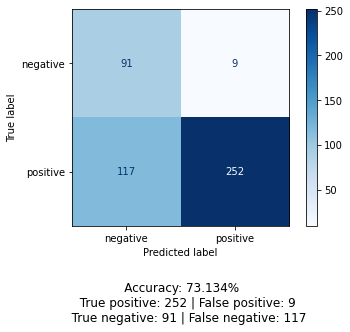

In [ ]:
# Plots performance results
disp, perf = get_and_plot_performance(output["result"], output["gt"])

# Exhaustive evaluation of FR systems

In this section we will evaluate all unique pairwise combinations of face detectors and face verifiers. There are a few caveats to this:

 - Currently, we are using the face recognition function provided in the deepface framework and it does not handle images with no faces. This might not sound like a problem, until one of the face detectors fail to detect a face in an image, raising the error. The opencv, ssd and dlib face detectors all failed at some point, so are currently not included in this exhaustive evaluation.

 - The 'mediapipe' face detector is currently bugged: the function does not recognize it as a valid face detector despite it being a valid one.

This means that the following face detectors and verifiers are considered in the exhaustive evaluation:
  - Face detectors:
    - MTCNN
    - RetinaFace
  - Face verifiers:
    - VGG-Face
    - Facenet
    - Facenet512
    - OpenFace
    - DeepFace
    - DeepID
    - ArcFace
    - Dlib
    - Ensemble

Note: the ensemble face verifier uses the VGG-Face, Facenet, OpenFace, and DeepFace models along with all three metrics: cosine, euclidean and euclidean_l2.

The performance results are printed subsequently. These results include a confusion matrix plot along with important performance metrics: accuracy, false positive, false negatives, true positives and true negatives.

In [6]:
# IMPORTANT NOTE / CONSIDERATION:
# When the backend fails to detect a face, the entire face recognition system
# fails with an error. It will be necessary to modify this behaviour at least
# within the face recogniton function for it to be able to continue!

# Performs exhaustive evaluation on the LFW subset
all_perf_results, gt = exhaustive_LFW_eval(LFW_SUB_ROOT)

Face detector: mtcnn
Face verifier: VGG-Face

vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:11<00:00, 50.1MB/s]
Finding representations: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [07:06<00:00,  1.10it/s]


find function lasts  526.0907669067383  seconds
 
Face detector: retinaface
Face verifier: VGG-Face

There are  100  representations found in  representations_vgg_face.pkl


Analyzing: 100%|██████████| 469/469 [05:12<00:00,  1.50it/s]


find function lasts  312.7265634536743  seconds
 
Face detector: mtcnn
Face verifier: Facenet

There are  100  representations found in  representations_facenet.pkl


Analyzing: 100%|██████████| 469/469 [05:14<00:00,  1.49it/s]


find function lasts  314.15241718292236  seconds
 
Face detector: retinaface
Face verifier: Facenet

There are  100  representations found in  representations_facenet.pkl


Analyzing: 100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


find function lasts  207.94068026542664  seconds
 
Face detector: mtcnn
Face verifier: Facenet512

facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:01<00:00, 81.7MB/s]
Finding representations: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_facenet512.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [05:19<00:00,  1.47it/s]


find function lasts  389.54742765426636  seconds
 
Face detector: retinaface
Face verifier: Facenet512

There are  100  representations found in  representations_facenet512.pkl


Analyzing: 100%|██████████| 469/469 [03:34<00:00,  2.19it/s]


find function lasts  214.0824737548828  seconds
 
Face detector: mtcnn
Face verifier: OpenFace

openface_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/openface_weights.h5
To: /root/.deepface/weights/openface_weights.h5
100%|██████████| 15.3M/15.3M [00:00<00:00, 130MB/s]
Finding representations: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_openface.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [05:04<00:00,  1.54it/s]


find function lasts  370.43763732910156  seconds
 
Face detector: retinaface
Face verifier: OpenFace

There are  100  representations found in  representations_openface.pkl


Analyzing: 100%|██████████| 469/469 [03:16<00:00,  2.38it/s]


find function lasts  196.79202461242676  seconds
 
Face detector: mtcnn
Face verifier: DeepFace

VGGFace2_DeepFace_weights_val-0.9034.h5 will be downloaded...


Downloading...
From: https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
To: /root/.deepface/weights/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
100%|██████████| 511M/511M [00:17<00:00, 29.3MB/s]
Finding representations: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_deepface.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [06:30<00:00,  1.20it/s]


find function lasts  539.6582036018372  seconds
 
Face detector: retinaface
Face verifier: DeepFace

There are  100  representations found in  representations_deepface.pkl


Analyzing: 100%|██████████| 469/469 [04:38<00:00,  1.69it/s]


find function lasts  278.34195494651794  seconds
 
Face detector: mtcnn
Face verifier: DeepID

deepid_keras_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/deepid_keras_weights.h5
To: /root/.deepface/weights/deepid_keras_weights.h5
100%|██████████| 1.61M/1.61M [00:00<00:00, 27.2MB/s]
Finding representations: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_deepid.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]


find function lasts  361.8880224227905  seconds
 
Face detector: retinaface
Face verifier: DeepID

There are  100  representations found in  representations_deepid.pkl


Analyzing: 100%|██████████| 469/469 [03:11<00:00,  2.44it/s]


find function lasts  191.8351924419403  seconds
 
Face detector: mtcnn
Face verifier: ArcFace

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 81.5MB/s]
Finding representations: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_arcface.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [05:23<00:00,  1.45it/s]


find function lasts  391.8440487384796  seconds
 
Face detector: retinaface
Face verifier: ArcFace

There are  100  representations found in  representations_arcface.pkl


Analyzing: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s]


find function lasts  211.8374044895172  seconds
 
Face detector: mtcnn
Face verifier: Dlib



Downloading...
From: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
To: /root/.deepface/weights/dlib_face_recognition_resnet_model_v1.dat.bz2


dlib_face_recognition_resnet_model_v1.dat is going to be downloaded


100%|██████████| 21.4M/21.4M [00:07<00:00, 2.85MB/s]
Finding representations: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_dlib.pkl  file. Please delete this file when you add new identities in your database.


Analyzing: 100%|██████████| 469/469 [04:51<00:00,  1.61it/s]


find function lasts  364.7772195339203  seconds
 
Face detector: retinaface
Face verifier: Dlib

There are  100  representations found in  representations_dlib.pkl


Analyzing: 100%|██████████| 469/469 [02:49<00:00,  2.76it/s]


find function lasts  169.89599204063416  seconds
 
Face detector: mtcnn
Face verifier: Ensemble

Ensemble learning enabled


Finding representations: 100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


Representations stored in  /content/data_sets/LFW_sub/gallery / representations_ensemble.pkl  file. Please delete this file when you add new identities in your database.


Analyzing:   0%|          | 0/469 [00:00<?, ?it/s]Downloading...
From: https://raw.githubusercontent.com/serengil/deepface/master/deepface/models/face-recognition-ensemble-model.txt
To: /root/.deepface/weights/face-recognition-ensemble-model.txt


face-recognition-ensemble-model.txt will be downloaded...



87.1kB [00:00, 15.1MB/s]                   
Analyzing: 100%|██████████| 469/469 [26:49<00:00,  3.43s/it]


find function lasts  1888.5136451721191  seconds
 
Face detector: retinaface
Face verifier: Ensemble

Ensemble learning enabled


Loading DeepFace: 100%|██████████| 4/4 [00:00<00:00, 394.97it/s]


There are  100  representations found in  representations_ensemble.pkl


Analyzing: 100%|██████████| 469/469 [19:16<00:00,  2.47s/it]

find function lasts  1156.326123714447  seconds
 


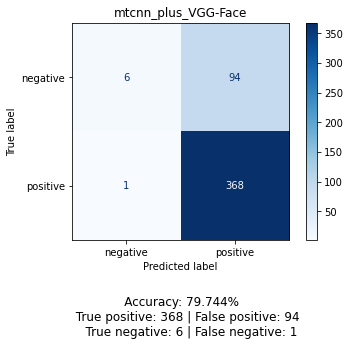

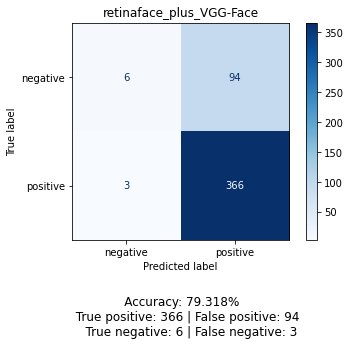

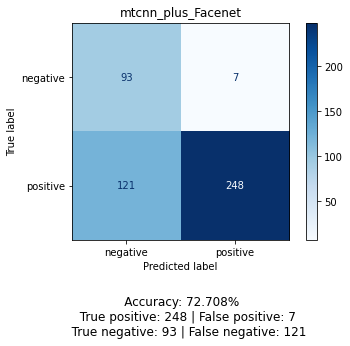

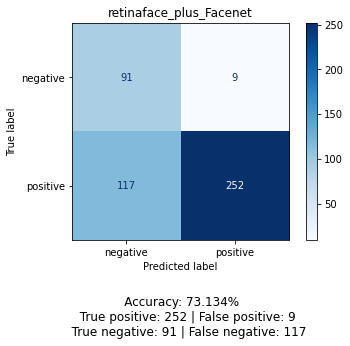

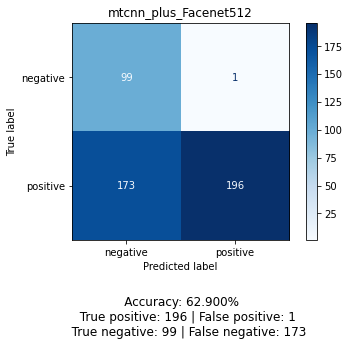

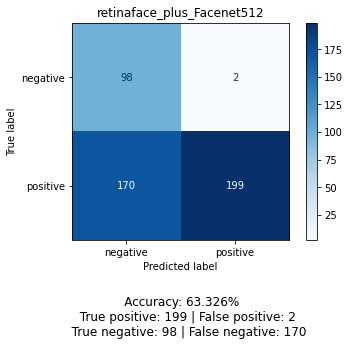

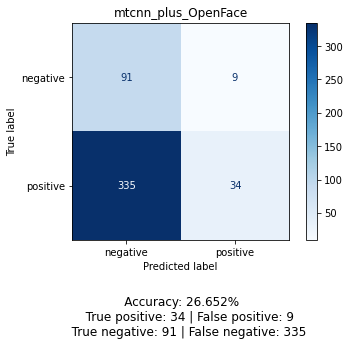

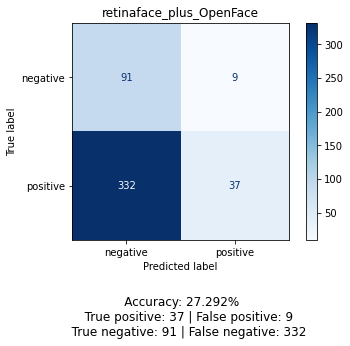

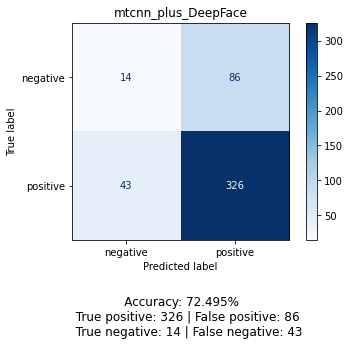

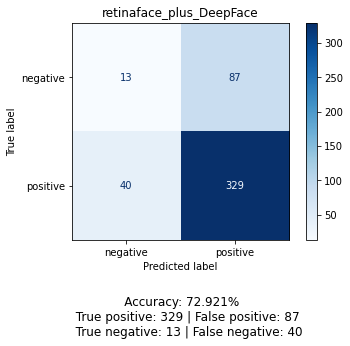

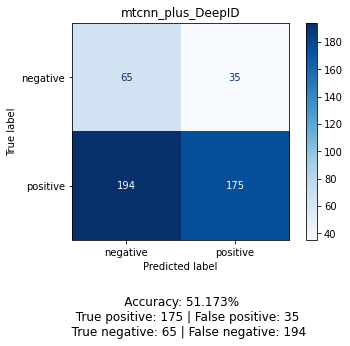

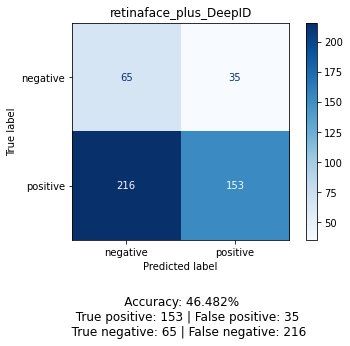

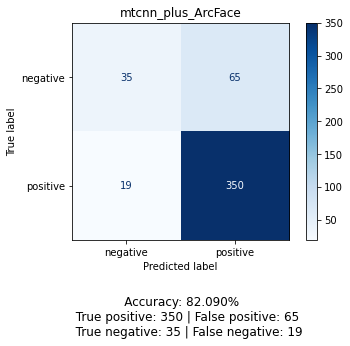

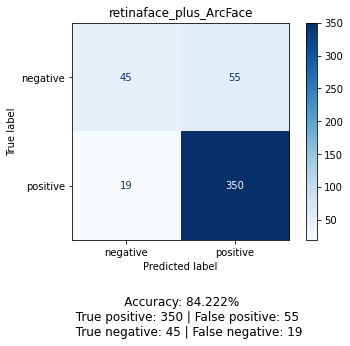

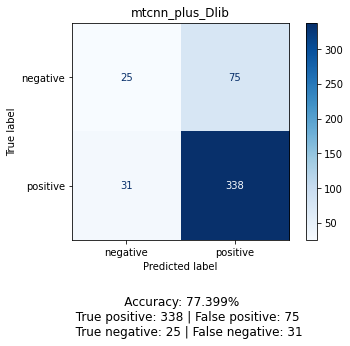

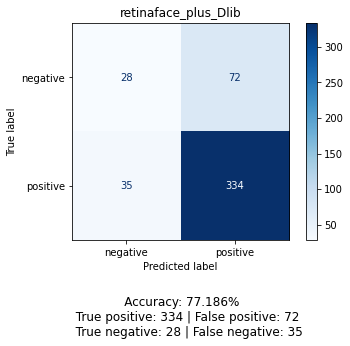

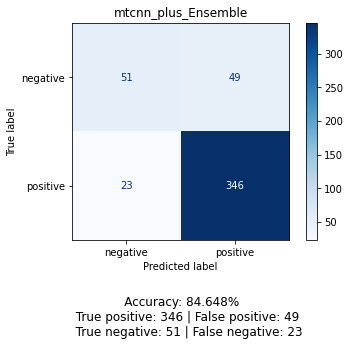

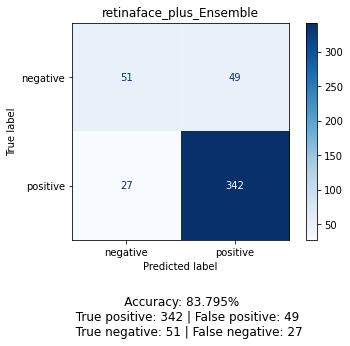

In [9]:
# Plots the performance results of each face detector + verifier pair
for result in all_perf_results:
    result.plot_performance()